In [1]:
## import necessary modules

import os
import numpy as np
import pylab as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

In [2]:
## load in the data, created using prep_csv.py
infile_name = '/home/ellie/research/lsst/LSST_sim.csv'
df_initial = pd.read_csv(infile_name)

In [3]:
## normalize the data, following a process based on Brian's data_loader

# select fields of interest
subspace = ["a*", "i-z", "a", "sini", "e", "v-vk", "r"]
df = df_initial[subspace]
df = df.dropna()

# normalize the data so that values fall in a range from 0-1
scaler = MinMaxScaler()
scaler.fit(df.to_numpy())
norm_data = scaler.fit_transform(df.to_numpy()) ## note "norm_data" is the same as X in Brian's code

In [8]:
## Fit the Gaussian mixture model (much of this code is pulled 
## directly or modified from Brian's reconstruction.ipynb file)

## should I re-do the BIC fitting for the new dataset to see if
## we should use a different number of components?
n_components = 71
gmm = GaussianMixture(n_components, covariance_type='full', max_iter=1000)

## fit the Gaussian mixture model
gmm.fit(norm_data)

GaussianMixture(max_iter=1000, n_components=71)

In [9]:
# predict the labels for the data samples in X using the trained model 
#(need to understand this part better) -MEW
labels = gmm.predict(norm_data)

## add labels to the pandas dataframe as a new column -MEW
df["labels"] = labels

## think the scores determined here indicate the confidence that each labelled group represents 
## a real group (if that makes sense -- may be off base on this / need to understand this better) -MEW
df["label_scores"] = gmm.predict_proba(norm_data).max(axis=1) # Scores of the labels in class - log-likelihood.


## add a field for log likelihood score for each sample
df["log_likelihood"] = gmm.score_samples(norm_data)

## scaler.inverse_transform transforms the GMM samples
## from the normalized (0..1) space back to the scale of the original simulation data 
samples = scaler.inverse_transform(gmm.sample(len(df))[0])

In [21]:
## sort the simulation samples from highest to lowest log likelihood scores
df_sorted = df.sort_values(by='log_likelihood', ascending=False) 

# create a new dataframe containing only the rows with the top 10 highest log likelihood scores
highest_ll_df = df_sorted.head(10)

#print(top_10_most_outlying)
indices = highest_ll_df.index.to_list() #retrieve indices of top 10 outliers
top10outliers = df_initial.loc[indices] 

print(top10outliers['ssObjectId'])

print(top10outliers['fullDesignation'])

457976    29138212465844254
458001    29138212465844254
457669    29138212465844254
457277    29138212465844254
457788    29138212465844254
457593    29138212465844254
458341    29138212465844254
458295    29138212465844254
457287    29138212465844254
457846    29138212465844254
Name: ssObjectId, dtype: int64
457976    2011 S100dloka
458001    2011 S100dloka
457669    2011 S100dloka
457277    2011 S100dloka
457788    2011 S100dloka
457593    2011 S100dloka
458341    2011 S100dloka
458295    2011 S100dloka
457287    2011 S100dloka
457846    2011 S100dloka
Name: fullDesignation, dtype: object


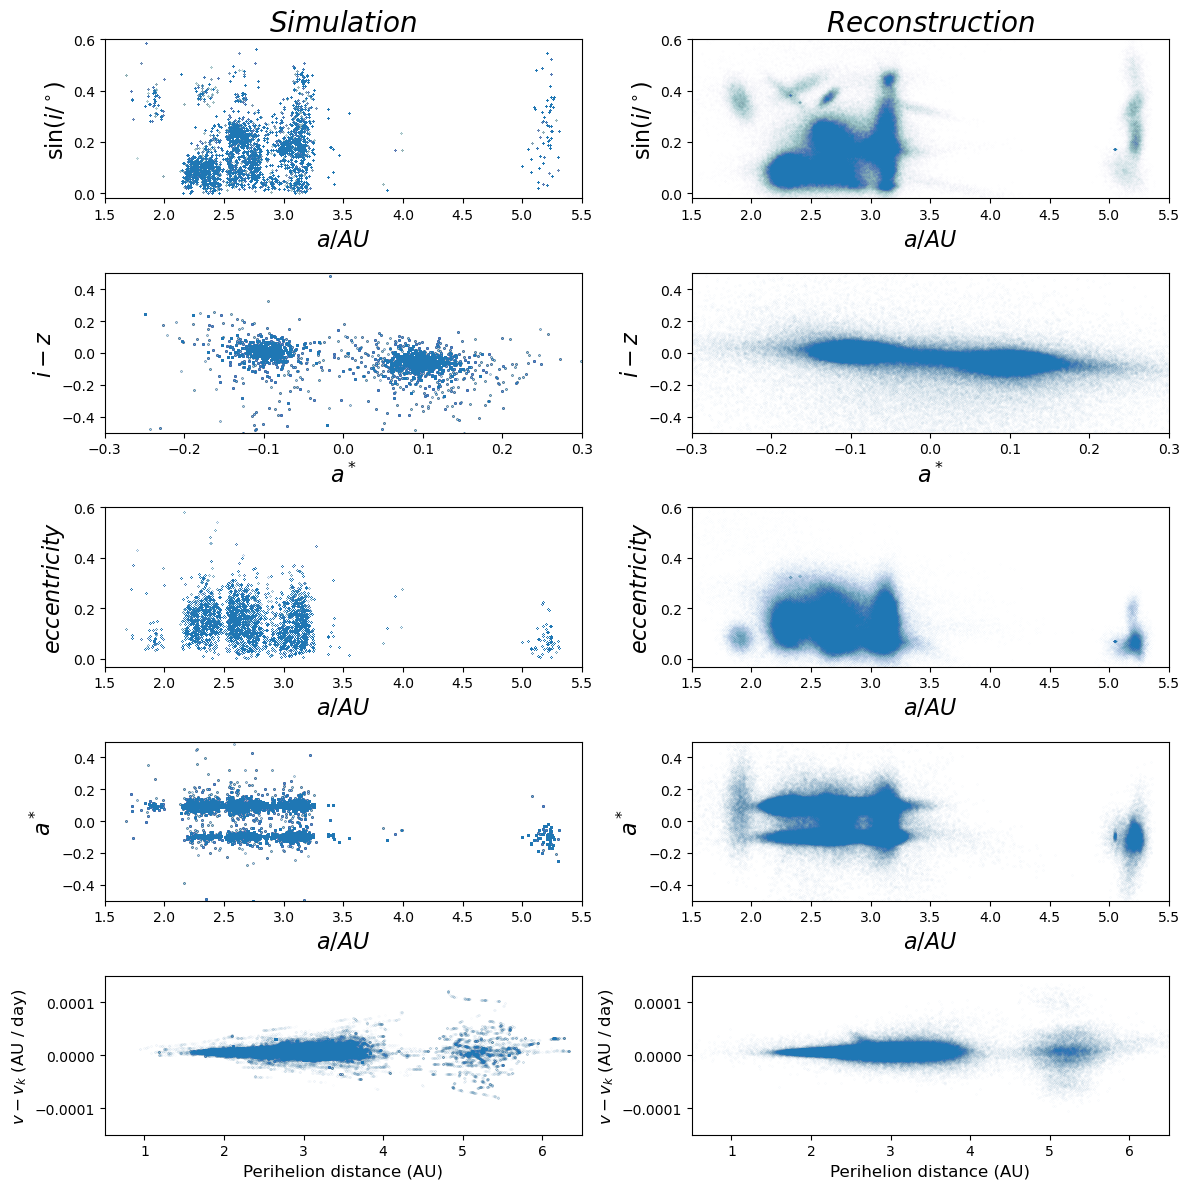

In [7]:
fig, axs = plt.subplots(5, 2, figsize=(12, 12))

#fig.suptitle("Comparison of simulation with the GMM reconstruction.")


axs[0][0].set_title(r"$Simulation$", fontsize=20)
axs[0][1].set_title(r"$Reconstruction$", fontsize=20)

## plot original "a" values vs "sini" values
## note s determines the size of the markers
## and alpha is transparency - MEW
axs[0][0].scatter(
    df["a"],
    df["sini"],
    s=1e-4,
    alpha=.5,
)

## plot the GMM-generated samples for "a" and "sini" 
## for comparison with the real values - MEW
axs[0][1].scatter(
    samples[:, 2],
    samples[:, 3],
    s=1e-4,
    alpha=.5,
)

## set the x and y labels for the two "a" vs "sini" plots - MEW
axs[0][0].set_xlabel(r"$a / AU$", fontsize=16)
axs[0][1].set_xlabel(r"$a / AU$", fontsize=16)

axs[0][0].set_ylabel(r"$\sin(i / ^\circ)$", fontsize=16)
axs[0][1].set_ylabel(r"$\sin(i / ^\circ)$", fontsize=16)

'''axs[0][0].set_title("Simulation", fontsize=20)
axs[0][1].set_title("GMM reconstruction", fontsize=20)'''

## plot simulation "a*" vs "i-z" - MEW
axs[1][0].scatter(
    df["a*"],
    df["i-z"],
    s=0.001,
    alpha=.5,
)

## plot GMM-generated "a*" vs "i-z" - MEW
axs[1][1].scatter(
    samples[:, 0],
    samples[:, 1],
    s=0.001,
    alpha=.5,
)

## set x and y labels for the "a*" vs "i-z" plots - MEW
axs[1][0].set_xlabel(r"$a^*$", fontsize=16)
axs[1][1].set_xlabel(r"$a^*$", fontsize=16)

axs[1][0].set_ylabel(r"$i - z$", fontsize=16)
axs[1][1].set_ylabel(r"$i - z$", fontsize=16)
'''
axs[1][0].set_title("Simulation")
axs[1][1].set_title("GMM reconstruction")'''

## plot simulation "a" vs "e" - MEW
axs[2][0].scatter(
    df["a"],
    df["e"],
    s=0.001,
    alpha=.25,
)

## plot GMM-generated "a" vs "e" -MEW
axs[2][1].scatter(
    samples[:, 2],
    samples[:, 4],
    s=0.001,
    alpha=.25,
)

## set x and y axis labels for "a" vs "e" plots - MEW
axs[2][0].set_xlabel(r"$a / AU$", fontsize=16)
axs[2][1].set_xlabel(r"$a / AU$", fontsize=16)

axs[2][0].set_ylabel(r"$eccentricity$", fontsize=16)
axs[2][1].set_ylabel(r"$eccentricity$", fontsize=16)

## plot simulation "a" vs "a*"
axs[3][0].scatter(
    df["a"],
    df["a*"],
    s=0.001,
    alpha=.5,
)

## plot GMM-generated "a" vs "a*"
axs[3][1].scatter(
    samples[:, 2],
    samples[:, 0],
    s=0.001,
    alpha=.5,
)

## set x and y axis labels for "a" vs "a*" plots - MEW
axs[3][0].set_xlabel(r"$a / AU$", fontsize=16)
axs[3][1].set_xlabel(r"$a / AU$", fontsize=16)

axs[3][0].set_ylabel(r"$a^*$", fontsize=16)
axs[3][1].set_ylabel(r"$a^*$", fontsize=16)

## plot simulation "v-vk" vs "r"
axs[4][0].scatter(
    df["r"],
    df["v-vk"],
    s=0.001,
    alpha=.5,
)

## plot GMM-generated "v-vk" vs "r"
axs[4][1].scatter(
    samples[:, 6],
    samples[:, 5],
    s=0.001,
    alpha=.5,
)


## set x and y axis labels for "a" vs "a*" plots - MEW
axs[4][0].set_xlabel("Perihelion distance (AU)", fontsize=12)
axs[4][1].set_xlabel("Perihelion distance (AU)", fontsize=12)

axs[4][0].set_ylabel("$v - v_k$ (AU / day)", fontsize=12)
axs[4][1].set_ylabel("$v - v_k$ (AU / day)", fontsize=12)

## set axis limits - MEW
axs[1][0].set_xlim(-.3, .3)
axs[1][1].set_xlim(-.3, .3)
axs[1][0].set_ylim(-.5, .5)
axs[1][1].set_ylim(-.5, .5)

axs[0][0].set_ylim(-0.02,.6)
axs[0][1].set_ylim(-0.02,.6)
axs[0][0].set_xlim(1.5,5.5)
axs[0][1].set_xlim(1.5,5.5)

axs[2][0].set_xlim(1.5,5.5)
axs[2][1].set_xlim(1.5,5.5)
axs[2][0].set_ylim(-.03, .6)
axs[2][1].set_ylim(-.03, .6)

axs[3][0].set_xlim(1.5,5.5)
axs[3][1].set_xlim(1.5,5.5)
axs[3][0].set_ylim(-.5, .5)
axs[3][1].set_ylim(-.5, .5)

axs[4][0].set_xlim(0.5,6.5)
axs[4][1].set_xlim(0.5,6.5)
axs[4][0].set_ylim(-.00015, .00015)
axs[4][1].set_ylim(-.00015, .00015)

## adjust padding and save the image - MEW
plt.tight_layout()
plt.savefig("recon.png", dpi=600)

In [ ]:
## The next step is to calculate the log_likelihood scores of the 
## simulated data points (not the GMM-generated data points) and rank them, 
## highest to lowest. 



In [ ]:
## This section directly utilizes code from Brian's reconstruction.ipynb file
## create an instance of AnomalyGenerator class
anom_gen = AnomalyGenerator()

## predict the labels for the data samples in X using the trained model (? need to understand this part better) -MEW
labels = anom_gen.model.predict(X)

## add labels to the pandas dataframe as a new column -MEW
df["labels"] = labels

## think the scores determined here indicate the confidence that each labelled group represents 
## a real group (if that makes sense -- may be off base on this / need to understand this better) -MEW
df["label_scores"] = anom_gen.model.predict_proba(X).max(axis=1) # Scores of the labels in class - log-likelihood.